In [10]:
import matplotlib.pyplot as plt
import numpy as np
import re
import json
import os
from sklearn.metrics import auc
from utils import get_percentile, import_graph

METRICS_LIST = ['degrees', 'k_cores', 'eccentricity', 'betweenness_centrality']
graph_names = ['wikivote',
               'hamsterster', 
               'DCAM', 
               'gnutella', 
               'github', 
               'dblp2010',
               'facebook',
               'slashdot']
method_names = ['RC','RW','BFS','DFS','MOD','DE']
METHOD_COLOR = {
    'AFD':'pink',
    'RC':'grey',
    'RW':'green',
    'DFS':'black', 
    'BFS':'blue', 
    'DE':'magenta', 
    'MOD':'red', 
    'LOD': 'yellow'
}

DUMPS_DIR = '../results/dumps_closed_shared'
SEED_COUNT = 8
TOP_PERCENTILE = 10

Load results into memory

In [11]:
def load_results(base_dir, graph):
    file_pattern = graph + r'_results_budget(\d+).json'
    budget, filename = None, None
    
    for filename in os.listdir(base_dir):
        match = re.match(file_pattern, filename)
        if match:
            budget = int(match.group(1))
            break
            
    if not budget:
        raise FileNotFoundError
    
    with open(os.path.join(base_dir, filename), 'r') as result_file:
        data = json.load(result_file)
    return data['crawler_avg'], data['history'], int(budget)

In [12]:
# draw plot 

def draw_nodes_history(history, crawler_avg, print_methods, graph_name, seed_count, budget):
    """
    Drawing history for every method(average are bold) and every seed(thin)
    """
    # TBD - ,graph_name,seed_count are only for filenames. need to clean them
    plt.figure(figsize=(10, 10))
    plt.grid()
    
    auc_res = {}
    
    for method, method_data in history.items():
        if method in print_methods:
            auc_res[method] = {}
            for seed_num, seed_data in list(method_data.items())[:seed_count]:
                data = np.array(seed_data['nodes'][:budget])
                auc_res[method][seed_num] = auc(x=np.arange(len(data)), y=data)
                plt.plot(data,
                         linewidth=0.5,
                         color=METHOD_COLOR[method])
    maxmethod = np.zeros(budget)         
    for i in range(budget):
        for method in print_methods:
            if crawler_avg[method]['nodes'][i]>maxmethod[i]:
                maxmethod[i] = crawler_avg[method]['nodes'][i]
    
    #maxmethod = np.array([np.max(i) for i in [crawler_avg[method]['nodes']] for method in crawler_avg])])
    print('maxmethod',maxmethod )
    for method, avg_data in crawler_avg.items():
        if method not in print_methods:
            continue
        data = np.array(avg_data['nodes'][:budget])
        auc_res[method]['average'] = auc(x=np.arange(len(data)), y=data)
        plt.plot(data-maxmethod,
                 linewidth=4,
                 color=METHOD_COLOR[method],
                 label=method)

    plt.legend()
    plt.savefig('../results/history/' + graph_name + '_history_' +
                str(seed_count) + '_seeds_' +
                str(budget) + 'iterations.png')
    plt.show()
    return auc_res
    
def draw_properties_history(percentile_set, crawler_avg, print_methods, graph_name, seed_count,
                            budget):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    plt.figure(figsize=(20, 20))
    
    auc_res = {}
    
    for method in print_methods:
        auc_res[method] = {}
        for prop in METRICS_LIST:
            # ремап для красивой отрисовки 2*2
            j = {'degrees': 0, 'k_cores': 1, 'eccentricity': 2, 'betweenness_centrality': 3}[prop] 
            
            data = np.array(crawler_avg[method][prop][:budget]) / seed_count / \
                   len(percentile_set[prop])
            auc_res[method][prop] = auc(x=np.arange(len(data)), y=data)
            axs[j // 2][j % 2].plot(data,
                                    label=method,
                                    color=METHOD_COLOR[method])
            axs[j // 2][j % 2].set_title(
                graph_name + '% nodes with ' + prop + ' from ' + str(len(percentile_set[prop])))
            axs[j // 2][j % 2].legend()

        axs[j // 2][j % 2].grid(True)
    fig.savefig('../results/history/' + graph_name + '_scores_' + 
                str(seed_count) + '_seeds_' + 
                str(budget) + 'iterations.png')
    plt.show()
    return auc_res

def plot_graph(graph_name, print_methods, budget_slices):
    crawler_avg, history, max_budget = load_results(DUMPS_DIR, graph_name)
    budget_slices.append(max_budget)
    
    big_graph = import_graph(graph_name)
    # берём топ 10 процентов вершин
    percentile, percentile_set = get_percentile(big_graph, graph_name, TOP_PERCENTILE)    
    
    if graph_name == 'gnutella': # большой костыль.Мы брали не тот эксцентриситет
        percentile_set['eccentricity'] = set(big_graph.nodes()).\
            difference(percentile_set['eccentricity'])
    
    for budget_slice in budget_slices:
        auc_res = draw_nodes_history(history, crawler_avg, print_methods, graph_name, SEED_COUNT, budget_slice)
        print('Nodes AUC for budget: '+ str(budget_slice) + ' ' + str(auc_res))
        
    auc_res = draw_properties_history(percentile_set, crawler_avg, print_methods, graph_name, SEED_COUNT,
                            max_budget)
    print('Properties AUC: ' + str(auc_res))
    

Wikivote nodes: 889 edges: 2914

maxmethod [ 17.25   36.625  53.875  79.875  87.5   106.25  116.    125.5   134.
 151.375 160.125 176.875 192.25  207.    222.    225.75  232.125 249.75
 254.75  265.75  275.    281.25  286.625 290.875 308.125 311.125 314.875
 316.5   318.625 319.75  321.875 326.    329.125 330.625 337.875 338.625
 339.    339.875 342.125 343.375 344.875 346.375 348.625 349.875 350.5
 351.75  352.25  356.125 359.25  359.75  360.875 362.5   363.375 364.375
 365.375 366.625 367.75  374.75  383.625 386.25  390.5   395.5   397.125
 398.875 402.    404.25  405.5   407.875 411.625 413.    415.25  418.25
 420.5   423.    424.625 432.125 436.25  438.625 440.125 441.75  444.75
 447.5   449.125 450.    451.25  453.    454.625 456.5   457.625 459.25
 461.75  462.875 465.    470.375 473.875 475.    477.    479.25  481.25
 483.   ]
Nodes AUC for budget: 100 {'MOD': {'360': 35113.5, '706': 34432.5, '703': 32989.0, '629': 30816.0, '84': 35367.0, '634': 29550.0, '819': 32735.0, '600': 30609.0, 'average': 32701.5}, 'RC'

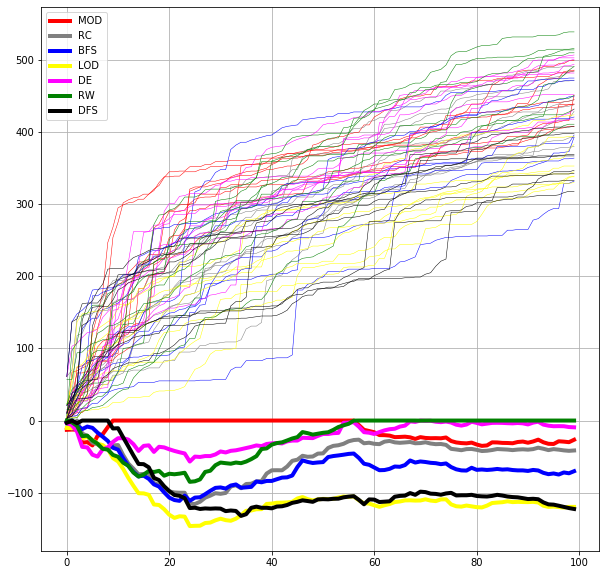

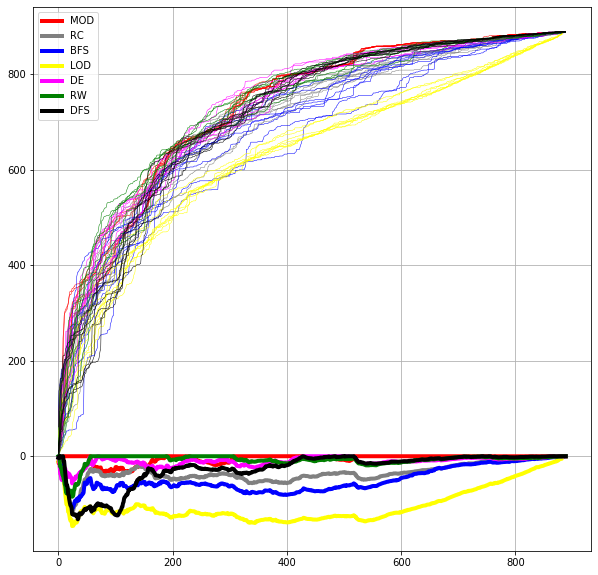

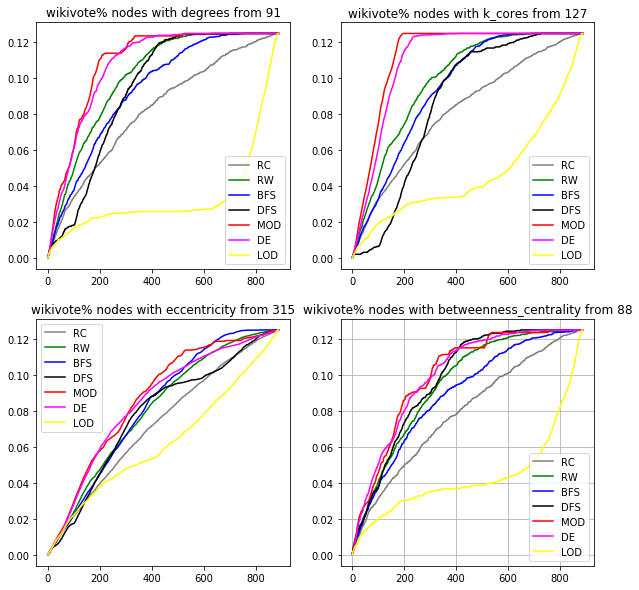

<Figure size 1440x1440 with 0 Axes>

In [13]:
plot_graph(graph_names[0], ['RC','RW','BFS','DFS','MOD','DE', 'LOD'], [100]) 

hamsterster nodes: 2000 edges: 16097

maxmethod [  30.      77.75   110.75   134.     163.875  193.625  219.25   259.125
  277.375  282.     303.875  322.5    353.375  391.125  399.5    404.75
  410.125  418.125  425.5    436.75   447.75   467.5    481.5    488.125
  494.875  506.     532.375  561.375  565.875  578.125  586.375  599.625
  628.5    636.5    642.25   653.125  666.     676.75   688.75   694.875
  698.625  703.625  710.5    719.375  725.     731.375  735.5    744.125
  748.75   754.75   773.125  787.     798.5    810.375  827.     834.75
  851.     866.375  879.75   894.375  905.625  916.     925.5    929.625
  945.875  952.125  957.75   963.     974.375  981.625  986.25   999.125
 1009.125 1013.5   1021.375 1026.5   1035.75  1038.125 1041.25  1044.625
 1047.625 1054.    1057.625 1062.25  1066.25  1074.75  1077.    1080.75
 1081.75  1084.875 1086.625 1088.625 1096.25  1099.    1105.125 1107.
 1110.375 1111.625 1118.5   1122.875]
Nodes AUC for budget: 100 {'BFS': {'453': 64746.5, '532': 57856.0, '1487': 51332.5

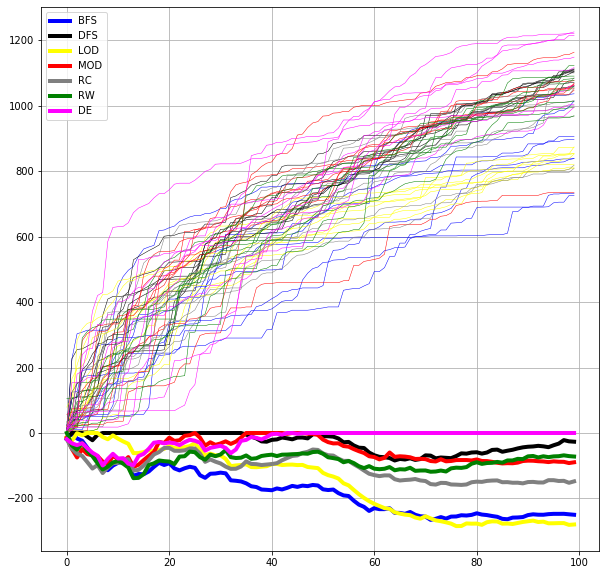

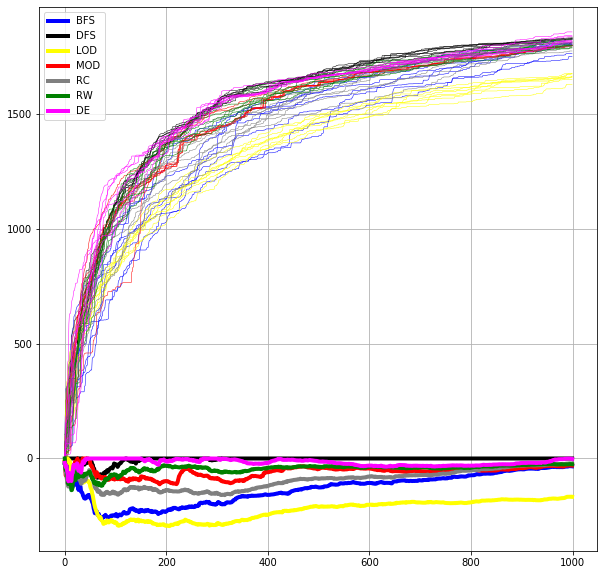

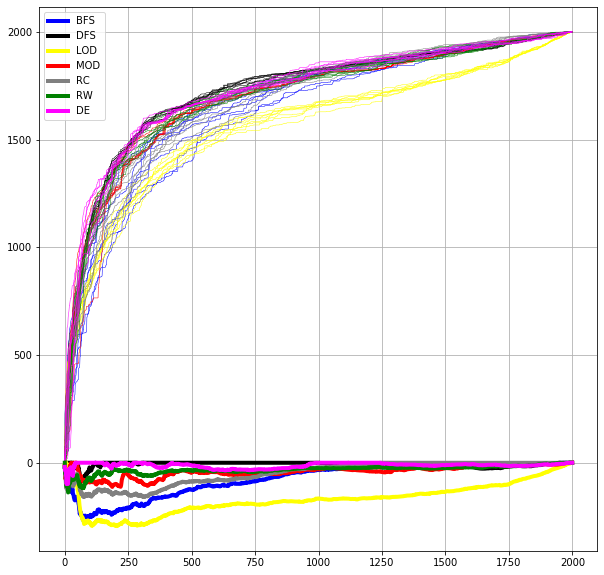

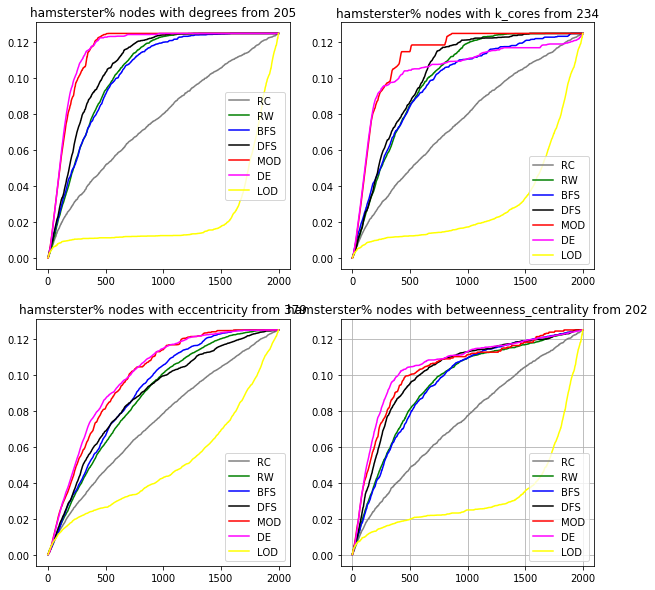

<Figure size 1440x1440 with 0 Axes>

In [14]:
plot_graph(graph_names[1], ['RC','RW','BFS','DFS','MOD','DE', 'LOD'], [100, 1000]) 

DCAM nodes: 2752 edges: 68741

maxmethod [  67.5    273.25   387.     480.75   515.625  540.125  641.5    669.
  704.375  760.75   778.25   798.75   817.5    823.5    837.     865.
  903.75   947.75   991.375 1014.875 1098.625 1118.125 1144.625 1162.625
 1186.625 1199.75  1220.625 1257.5   1278.75  1292.5   1322.875 1330.625
 1339.125 1356.375 1368.    1374.625 1383.    1400.    1408.    1415.75
 1421.375 1427.25  1437.25  1445.625 1451.25  1456.5   1464.    1472.125
 1482.    1492.125 1499.25  1505.625 1515.375 1522.75  1529.875 1543.125
 1551.625 1558.875 1567.75  1576.625 1589.125 1601.375 1607.5   1610.625
 1621.625 1642.875 1651.125 1659.375 1665.    1668.875 1672.375 1679.5
 1684.    1687.5   1689.125 1692.875 1695.5   1698.375 1702.    1706.375
 1707.5   1709.875 1712.75  1715.75  1719.    1722.    1724.125 1727.
 1729.75  1733.5   1735.75  1738.5   1742.5   1744.75  1746.875 1751.375
 1761.625 1765.    1770.5   1775.875]
Nodes AUC for budget: 100 {'DFS': {'3244277': 67644.0, '267729353': 125084.5, '162136295

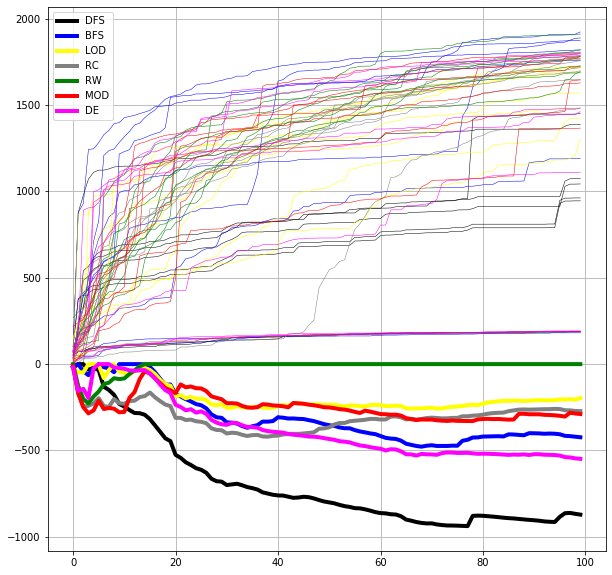

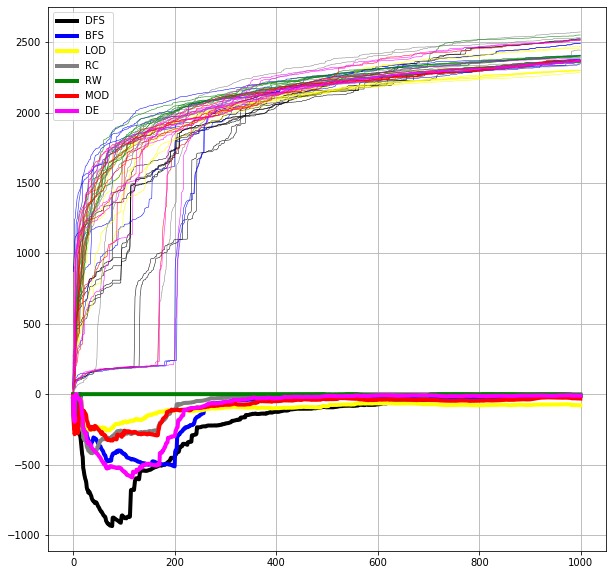

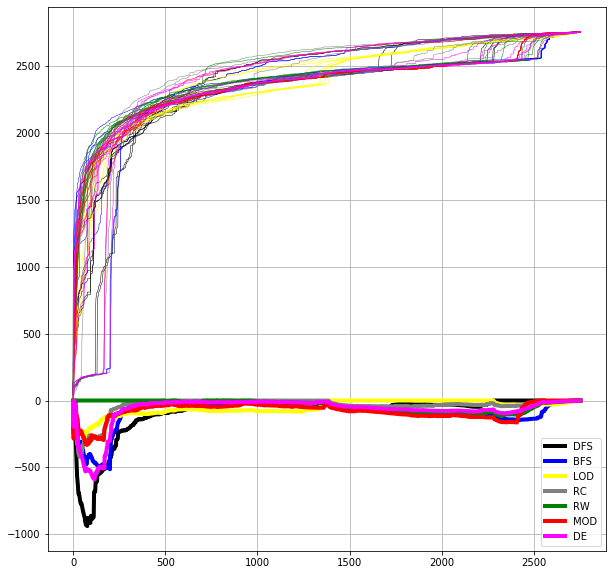

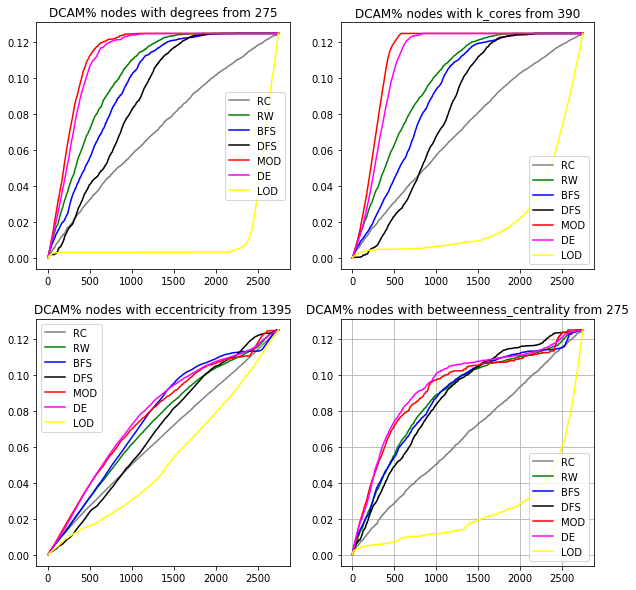

<Figure size 1440x1440 with 0 Axes>

In [15]:
plot_graph(graph_names[2], ['RC','RW','BFS','DFS','MOD','DE', 'LOD'], [100, 1000]) 

gnutella nodes: 36682 edges: 88328

In [16]:
# plot_graph(graph_names[3], ['RC','RW','BFS','DFS','MOD','DE'], [100, 1000, 10000]) 

github nodes: 120865 edges: 439858

maxmethod [   27.875   233.25    597.125  1467.75   1681.875  1948.5    2347.875
  2602.125  3452.625  4386.5    4905.     4984.     5482.     5646.25
  5826.375  6238.     6271.5    6340.625  6403.75   6547.75   6663.
  6836.125  7289.     7537.625  7822.     7997.25   8221.375  8380.5
  8481.375  8601.875  8736.75   8882.75   9050.5    9209.875  9540.625
  9713.375  9851.125  9957.    10068.    10196.625 10322.625 10425.
 10551.125 10637.625 10814.125 10927.75  11010.875 11119.75  11210.375
 11309.75  11448.625 11545.75  11749.375 11857.375 11909.75  11991.625
 12110.875 12256.375 12337.875 12408.    12498.375 12584.25  12712.125
 12760.25  12946.875 13051.625 13126.375 13254.125 13354.375 13436.625
 13518.75  13569.5   13634.    13735.75  13842.25  13936.875 13992.875
 14108.25  14185.125 14276.375 14378.25  14540.125 14597.125 14657.
 14757.125 14863.5   14940.75  14992.    15045.25  15137.    15251.875
 15326.75  15437.    15536.375 15688.375 15750.125 15787.25  15833.125
 15937.3

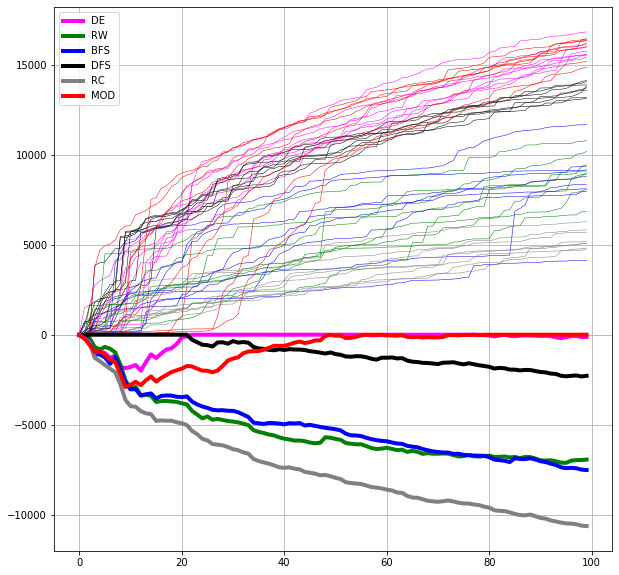

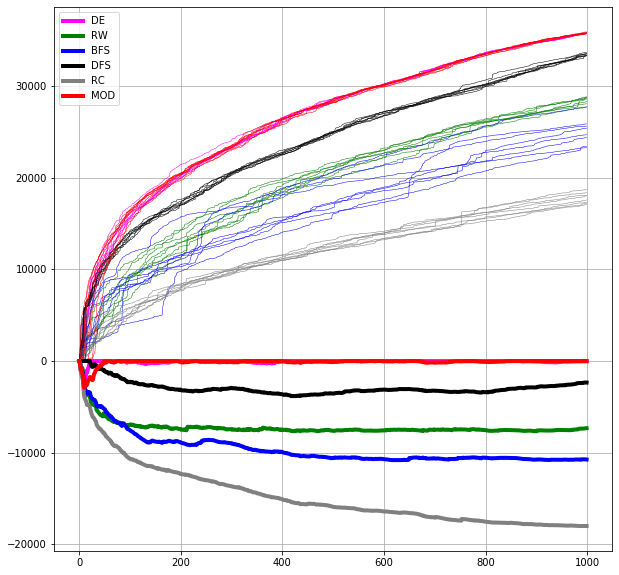

/home/yatskov/Documents/crawling/venv/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/yatskov/Documents/crawling/venv/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


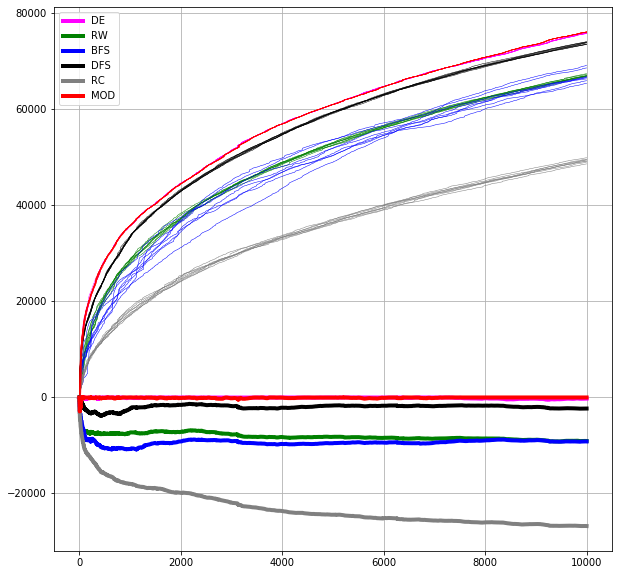

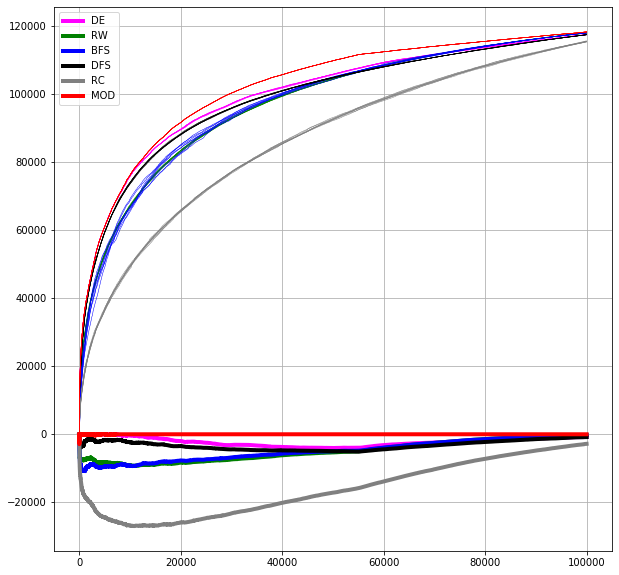

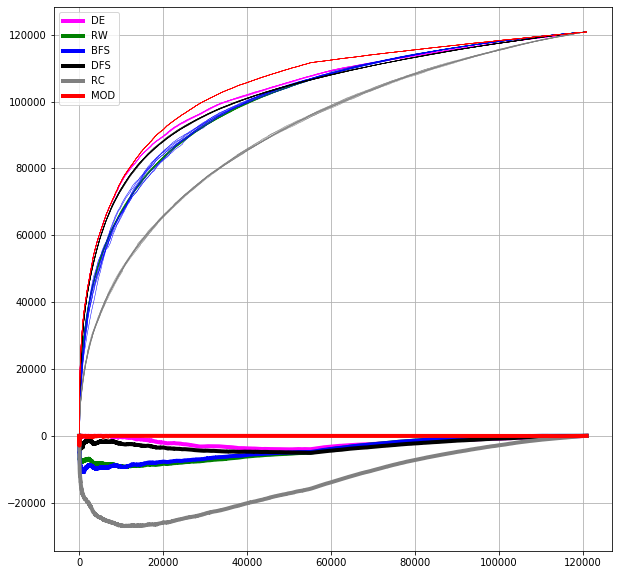

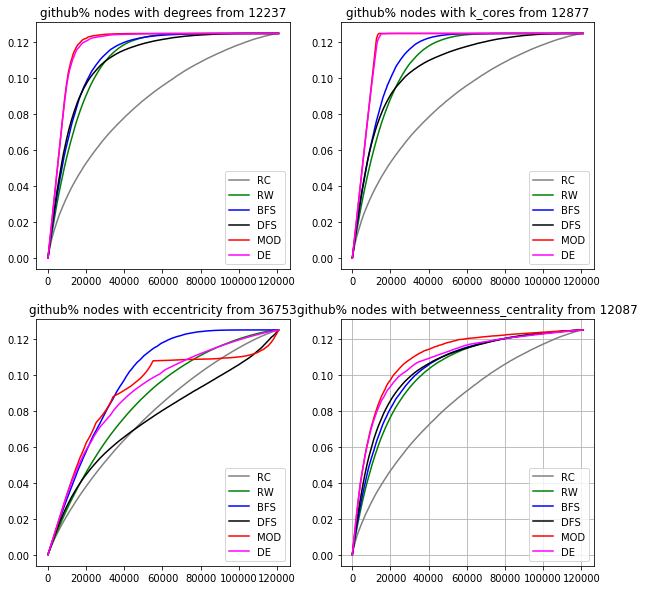

<Figure size 1440x1440 with 0 Axes>

In [17]:
plot_graph(graph_names[4], ['RC','RW','BFS','DFS','MOD','DE'], [100, 1000, 10000, 100000]) 
 

dblp2010 nodes: 226413 edges: 716460

maxmethod [  14.375   28.875   62.75    91.875  112.75   132.125  143.375  146.625
  152.125  159.25   170.     179.125  185.625  204.625  210.25   220.625
  233.75   252.375  258.625  263.625  266.625  273.375  279.375  296.375
  307.375  329.5    333.     345.     347.5    365.     383.5    395.25
  421.625  428.375  444.125  455.5    467.125  484.625  492.     510.625
  515.375  528.75   545.125  568.375  578.25   592.25   604.75   617.25
  624.375  644.375  664.375  693.25   703.125  708.625  713.625  731.875
  759.625  774.75   784.5    792.     802.125  815.125  827.25   881.
  892.     904.25   917.875  936.125  950.125  951.375  959.375  964.875
  969.875  984.125  997.625 1016.375 1024.75  1045.875 1077.625 1094.75
 1129.    1147.    1161.125 1172.375 1187.875 1197.875 1208.625 1212.75
 1223.    1228.    1230.375 1241.25  1245.    1258.5   1265.375 1285.625
 1303.25  1320.5   1331.75  1342.625]
Nodes AUC for budget: 100 {'BFS': {'221681': 21468.5, '86394': 20915.0, '94074': 58

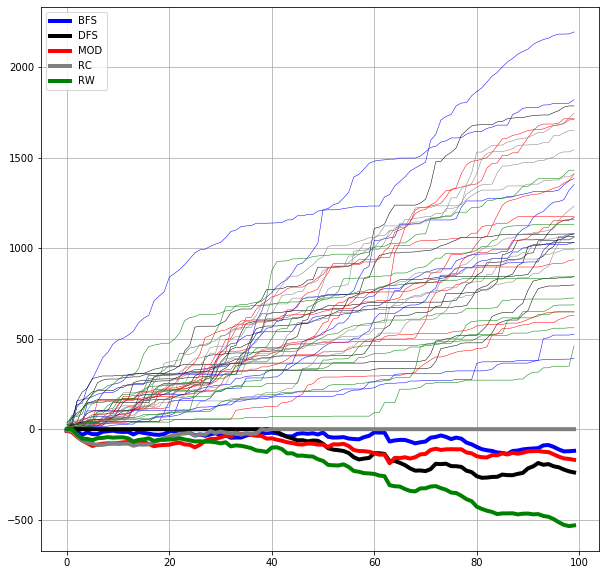

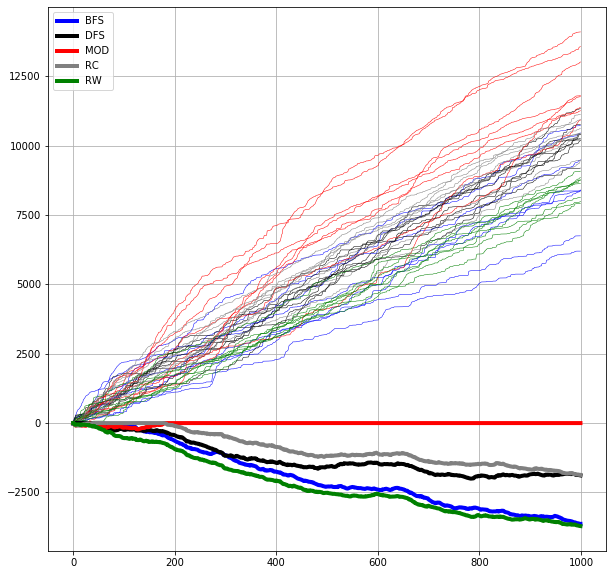

/home/yatskov/Documents/crawling/venv/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/yatskov/Documents/crawling/venv/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


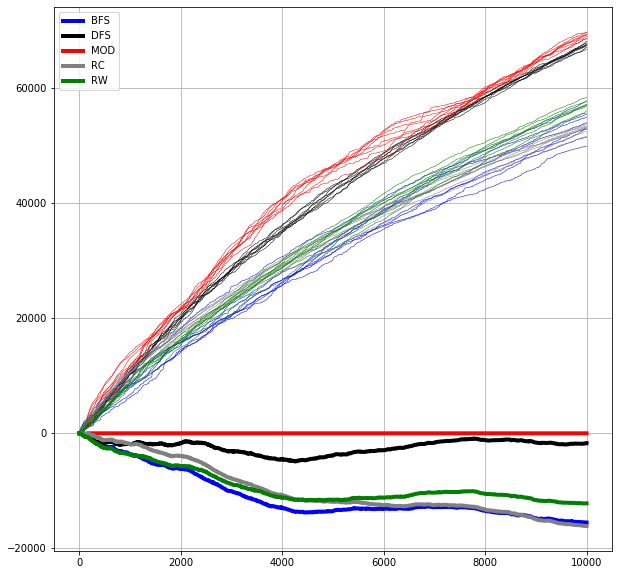

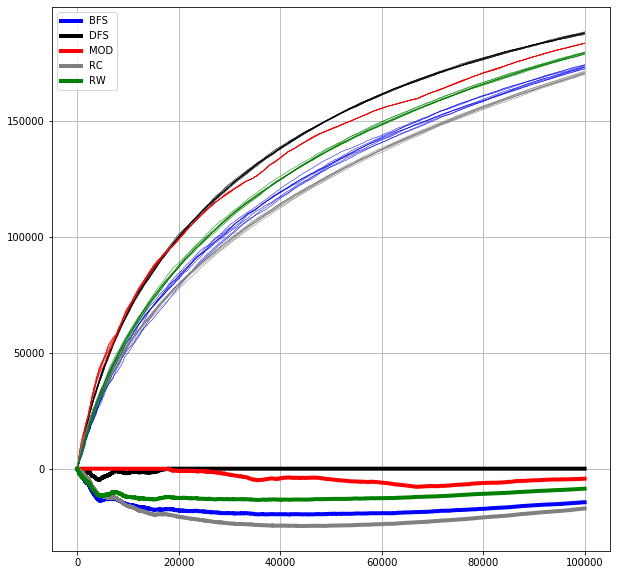

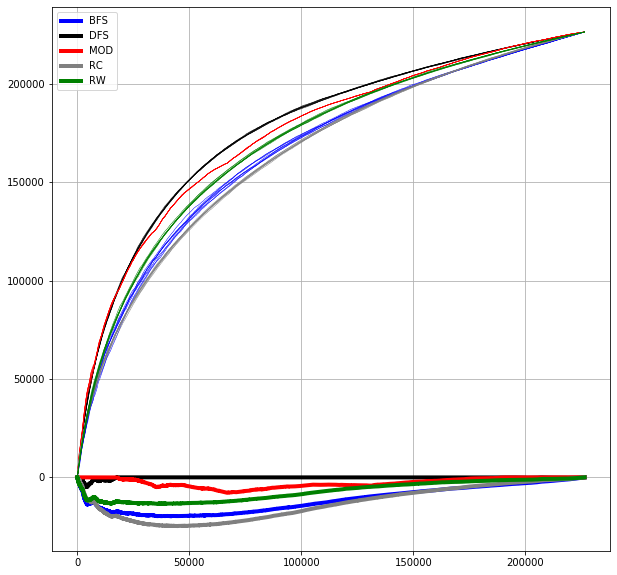

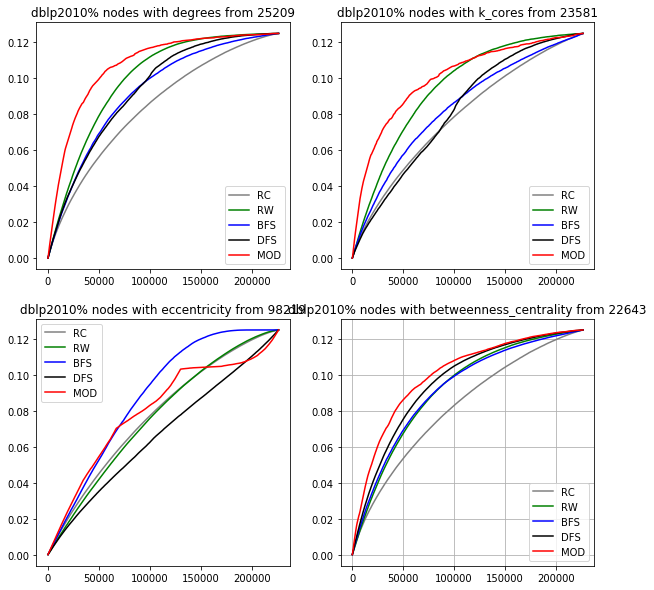

<Figure size 1440x1440 with 0 Axes>

In [18]:
plot_graph(graph_names[5], ['RC','RW','BFS','DFS','MOD'], [100, 1000, 10000, 100000]) 

facebook

maxmethod [  73.625  189.625  548.875  698.625  786.375  812.625  895.375 1033.875
 1103.625 1229.375 1289.75  1352.125 1383.125 1458.625 1541.5   1554.75
 1574.125 1613.25  1667.    1876.125 1890.375 1909.125 1943.    1981.875
 2018.75  2046.    2090.    2112.875 2137.    2172.875 2189.75  2209.
 2227.125 2250.5   2270.    2331.625 2426.375 2460.5   2477.    2484.625
 2541.625 2603.5   2643.875 2680.625 2707.125 2748.5   2777.375 2804.5
 2839.75  2861.125 2877.    2889.75  2926.5   2970.5   3008.125 3039.875
 3057.5   3113.    3205.375 3248.875 3295.75  3342.375 3406.375 3451.5
 3538.    3569.25  3622.875 3671.875 3708.25  3747.5   3832.75  3926.25
 3954.875 3986.5   4024.625 4126.625 4175.125 4215.25  4234.75  4297.75
 4373.625 4430.625 4456.875 4493.625 4528.875 4575.5   4619.875 4653.625
 4731.125 4813.625 4881.5   4911.    4963.5   4994.125 5053.875 5096.5
 5130.125 5173.625 5227.25  5248.   ]
Nodes AUC for budget: 100 {'RW': {'47196': 187055.5, '2769': 272074.5, '54390': 225233.0

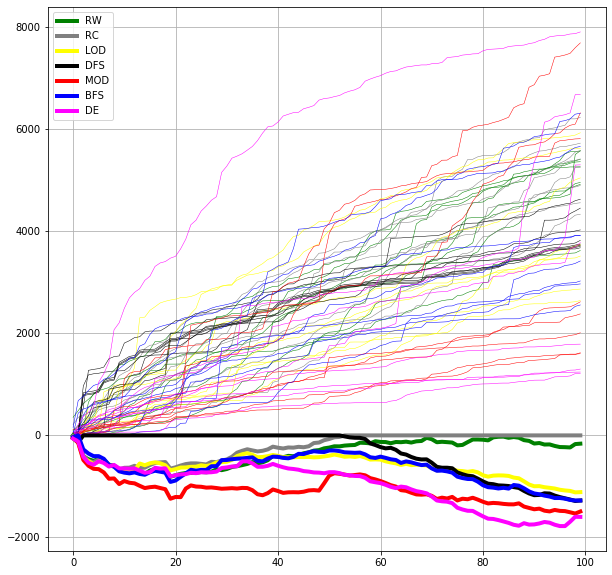

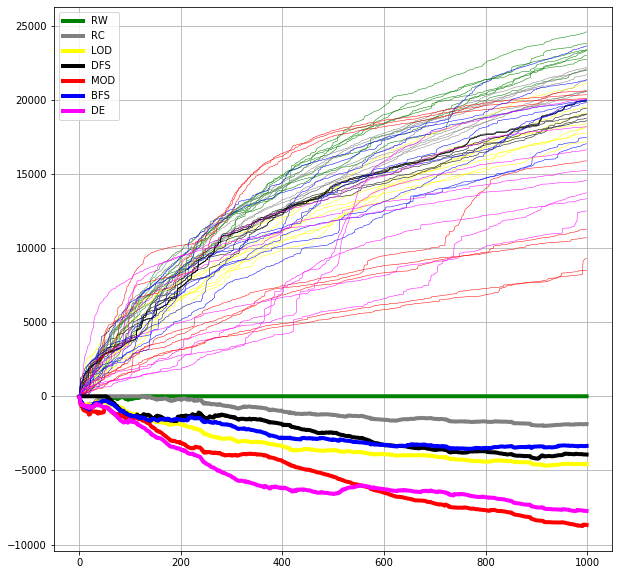

/home/yatskov/Documents/crawling/venv/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/yatskov/Documents/crawling/venv/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/yatskov/Documents/crawling/venv/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


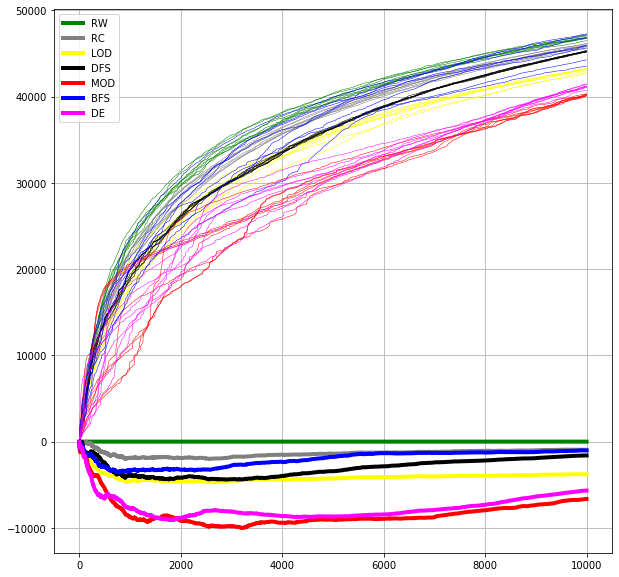

IndexError: list index out of range

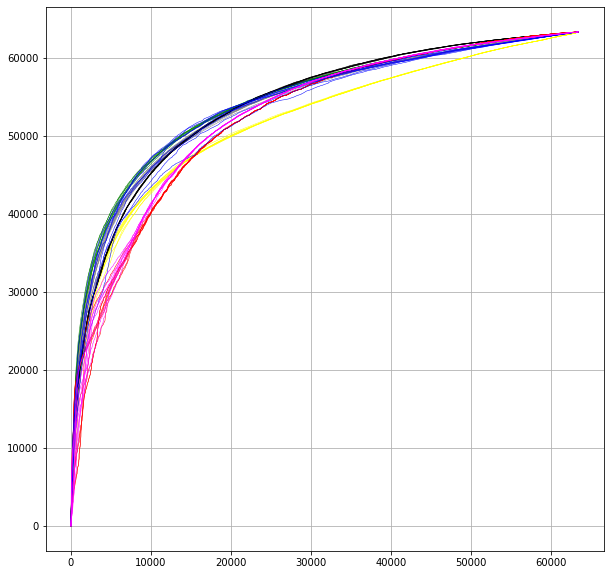

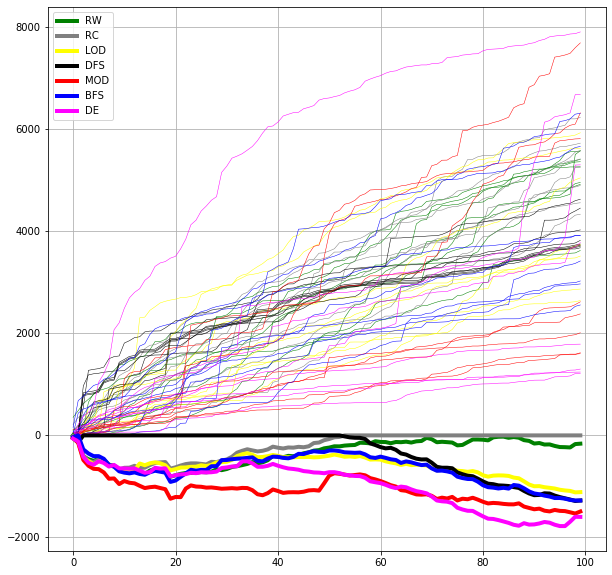

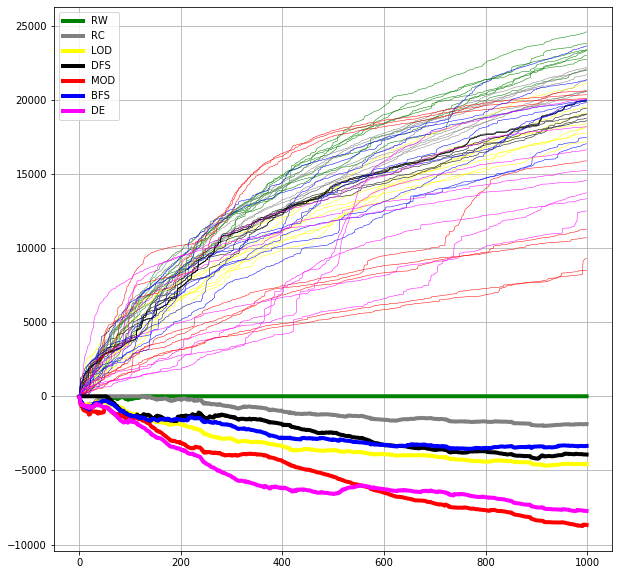

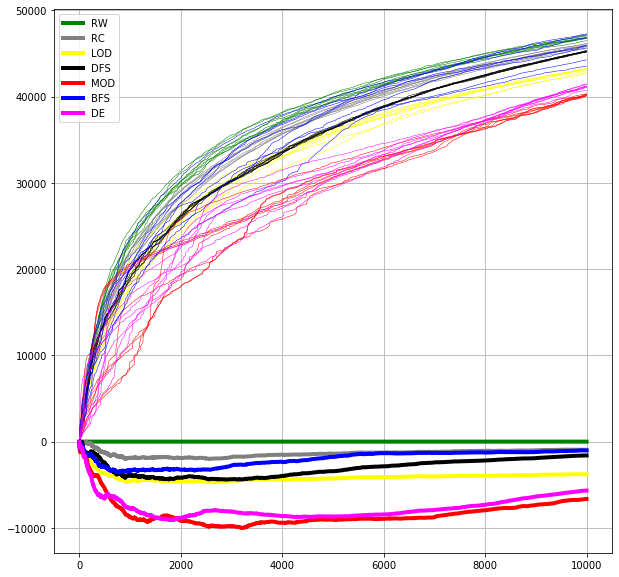

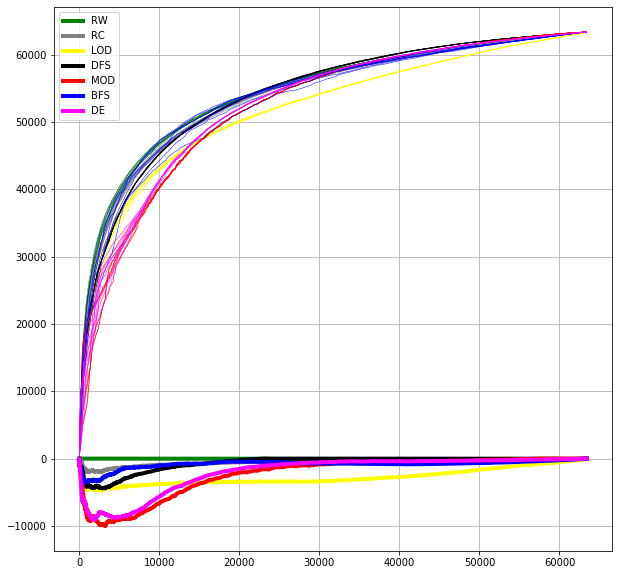

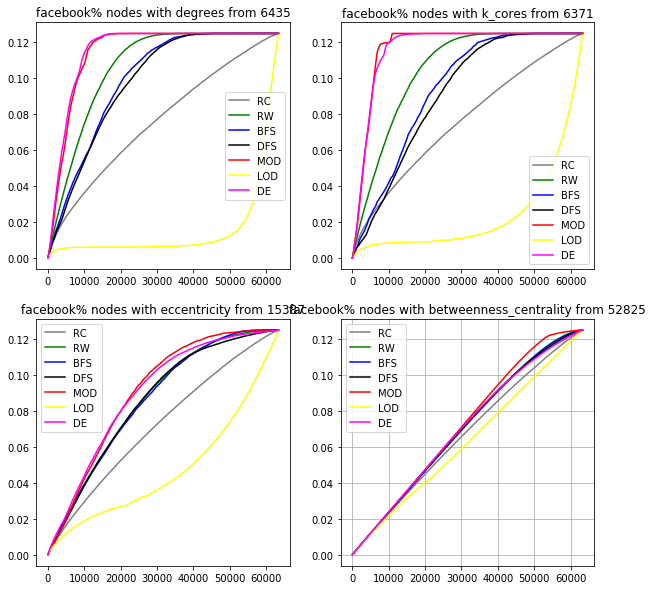

<Figure size 1440x1440 with 0 Axes>

In [21]:
plot_graph(graph_names[6], ['RC','RW','BFS','DFS','MOD', 'LOD', 'DE'], [100, 1000, 10000]) 

slashdot

maxmethod [   45.125   176.      288.25    615.125   734.5    1168.875  1225.625
  1281.875  1357.     1441.375  1535.875  1586.75   1659.625  1699.875
  1859.125  2021.625  2426.     2509.375  3127.75   3551.125  3702.25
  3838.75   3964.625  4142.375  4244.5    4657.125  4838.5    4947.125
  5069.125  5496.     5614.125  5695.25   5762.5    5897.25   6010.
  6105.875  6209.     6305.375  6445.75   6557.625  6672.125  6794.125
  6870.5    6966.5    7042.     7132.     7237.     7341.25   7474.
  7549.125  7635.875  7748.625  7836.5    7960.125  8078.875  8161.375
  8246.5    8320.5    8412.375  8498.     8572.375  8650.75   8725.125
  8805.75   8890.125  8964.125  9032.     9094.5    9153.125  9257.625
  9349.875  9406.625  9470.625  9538.625  9604.875  9672.5    9734.25
  9799.625  9868.625  9944.5   10014.25  10089.125 10151.75  10211.75
 10261.375 10335.25  10392.75  10447.375 10518.125 10582.875 10641.
 10704.125 10763.    10835.125 10893.875 10947.875 11012.    11062.75
 11115.75

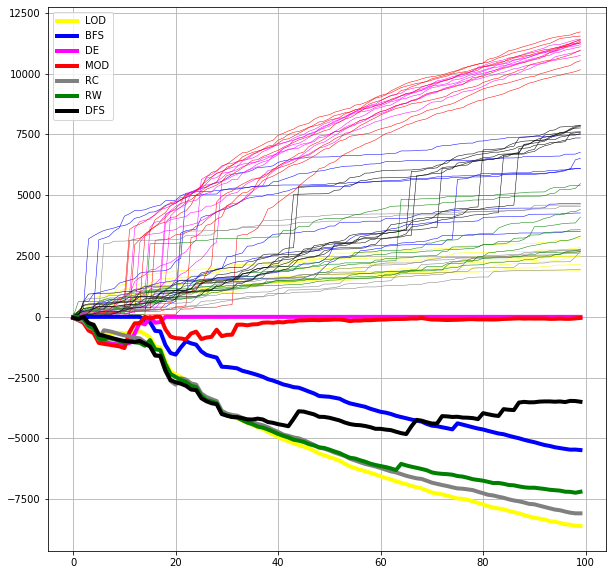

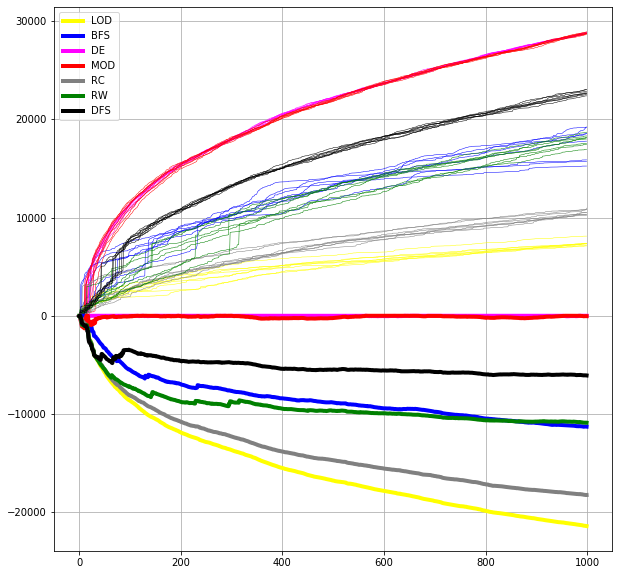

/home/yatskov/Documents/crawling/venv/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/yatskov/Documents/crawling/venv/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


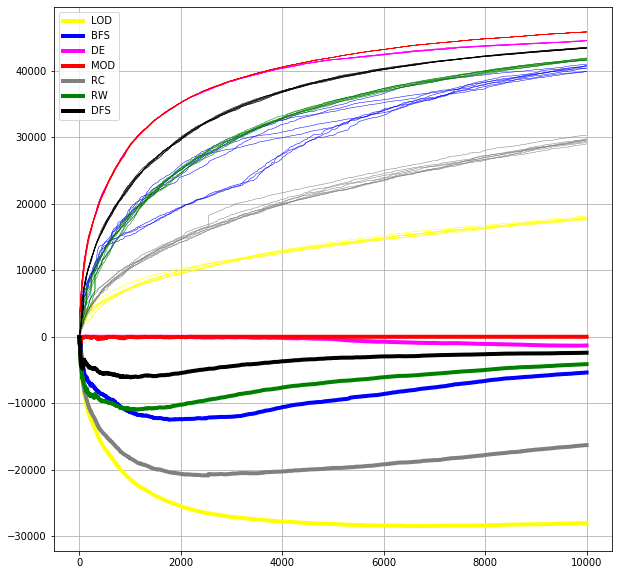

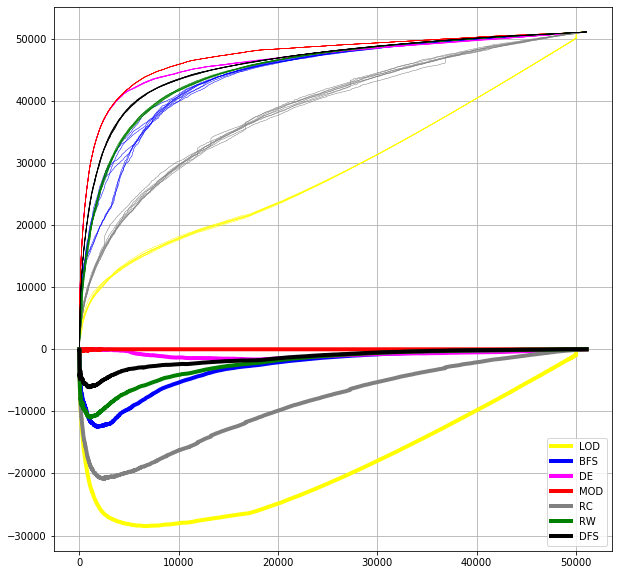

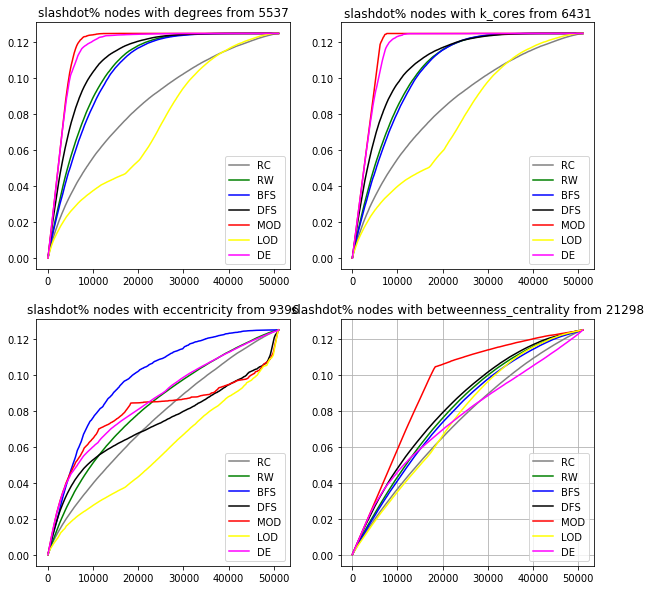

<Figure size 1440x1440 with 0 Axes>

In [22]:
plot_graph(graph_names[7], ['RC','RW','BFS','DFS','MOD', 'LOD', 'DE'], [100, 1000, 10000]) 